# Final Project

## Loading data

In [1]:
from sklearn.exceptions import DataConversionWarning
import warnings
# from pandas.core.common import SettingWithCopyWarning
from dash.dependencies import Input, Output
from dash import html
from dash import dcc
import dash
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
import pandas as pd
import statistics
import plotly.io as pio
from statistics import mean
import xgboost
import math
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import matthews_corrcoef
from tensorflow import keras
import tensorflow as tf
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
from scikeras.wrappers import KerasRegressor
tf.random.set_seed(42)
pio.renderers.default = 'notebook'
pio.templates.default = "plotly_dark"
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)
data1 = pd.read_excel("globalterrorismdb_0221dist.xlsx")
data2 = pd.read_excel("gtd1993_0221dist.xlsx")
# data1 is the main archives while data2 is the missing 1993 records that were recovered later.
# These two files are loaded into dataframes and concatenated.
raw_data = pd.concat([data1, data2], axis=0, ignore_index=True)
raw_data = raw_data.sort_values('eventid')
# The rows are sorted into proper chronological order
raw_data = raw_data.rename(columns={'iyear': 'Year', 'imonth': 'Month', 'iday': 'Day',
                           'country': 'Country Code', 'country_txt': 'Country', 'region': 'Region Code'})
# The columns are given more intuitive names


## Exploratory Data Analysis

This section will be exploratory data analysis in order to find more patterns, gather more info about the data and find any hidden insights.

In [6]:
raw_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 201931 entries, 0 to 201182
Columns: 135 entries, eventid to related
dtypes: datetime64[ns](1), float64(54), int64(23), object(57)
memory usage: 209.5+ MB


### How many attacks in the dataset?

In [7]:
print(f"There are {raw_data.shape[0]} attacks in the data.")


There are 201931 attacks in the data.


Graphics and visuals are better at conveying meaning. The next section of my project is made up of various descriptive statistics and answering various research questions. Some graphs and charts will be static as they won't have variables that can really be changed while some graphs and charts are interactive. 

### How many attacks by year?

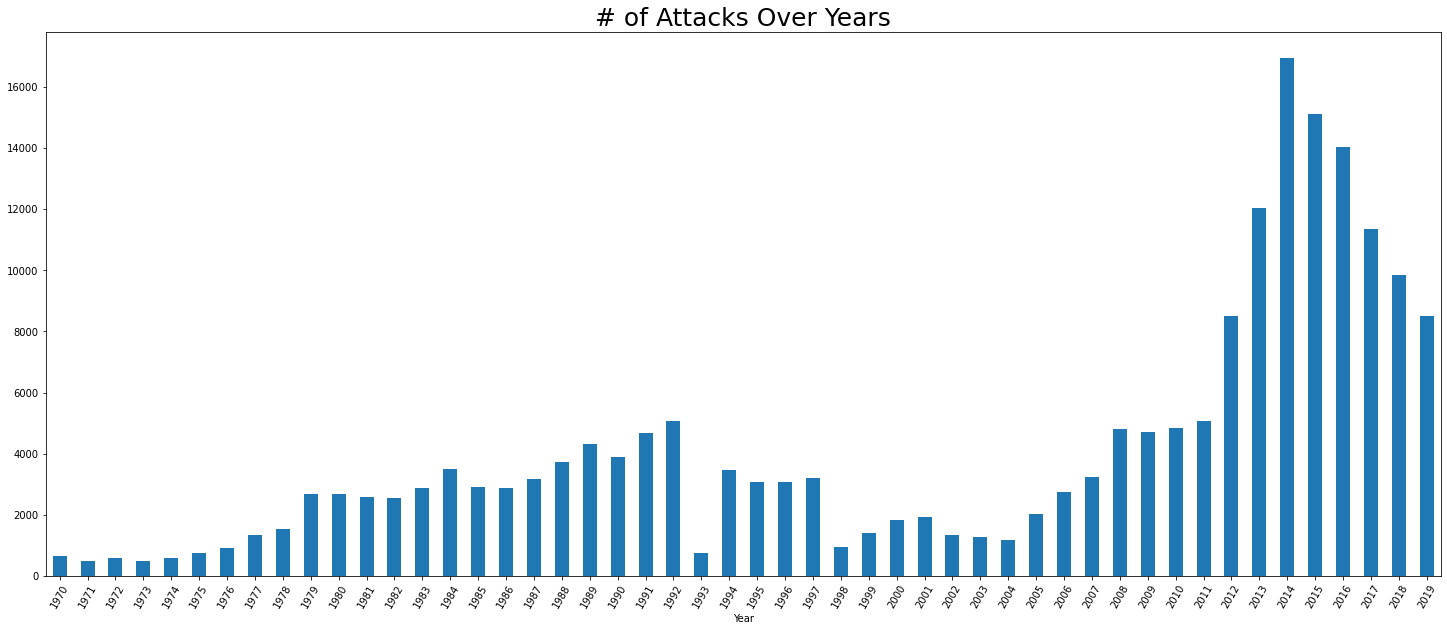

In [8]:
raw_data.groupby('Year')\
        .size()\
        .plot(kind='bar', figsize=(25, 10), rot=60)
plt.title('# of Attacks Over Years', size=25)
plt.show()


### How many attacks sorted by region and which region has suffered the most attacks?

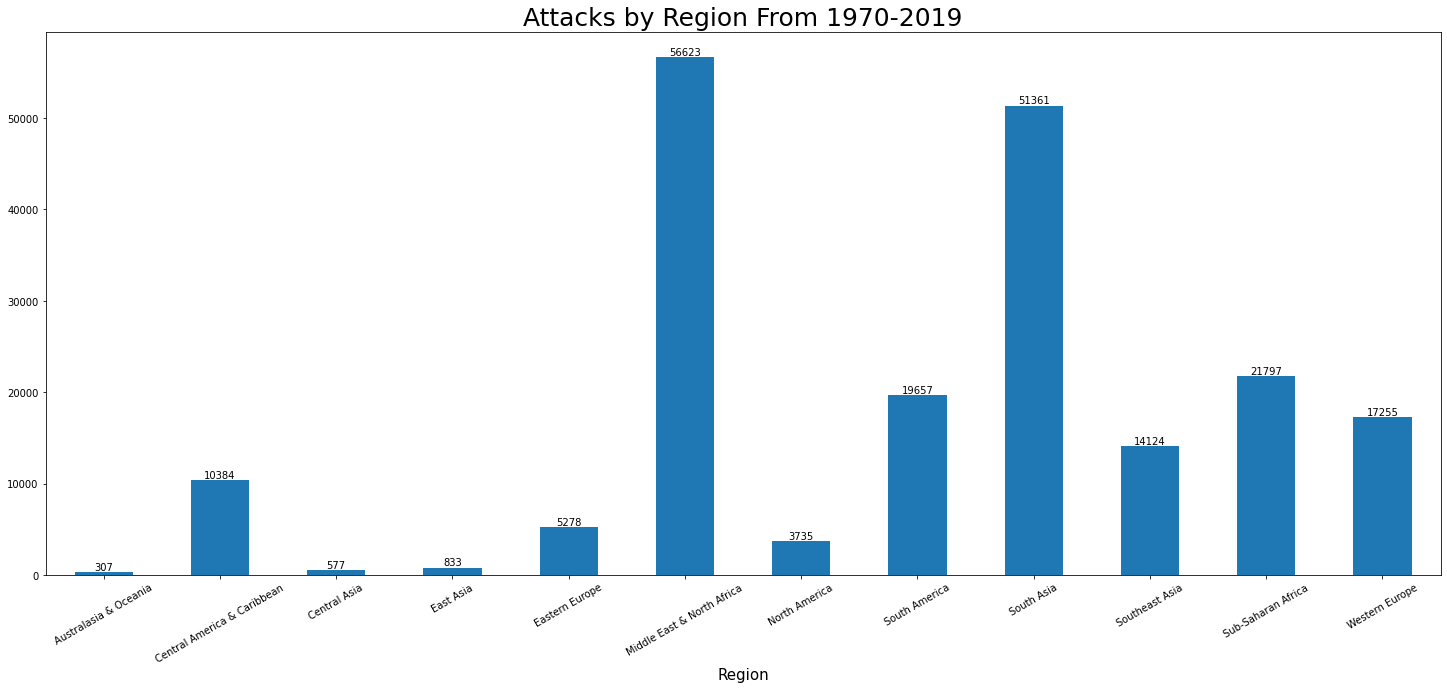

In [9]:
attacks_by_region = raw_data.groupby('region_txt')\
                            .size()\
                            .plot(kind='bar', figsize=(25, 10), rot=30)
plt.bar_label(attacks_by_region.containers[0])
plt.title('Attacks by Region From 1970-2019', size=25)
plt.xlabel('Region', fontsize=15)
plt.show()


### Which country has suffered the most attacks?

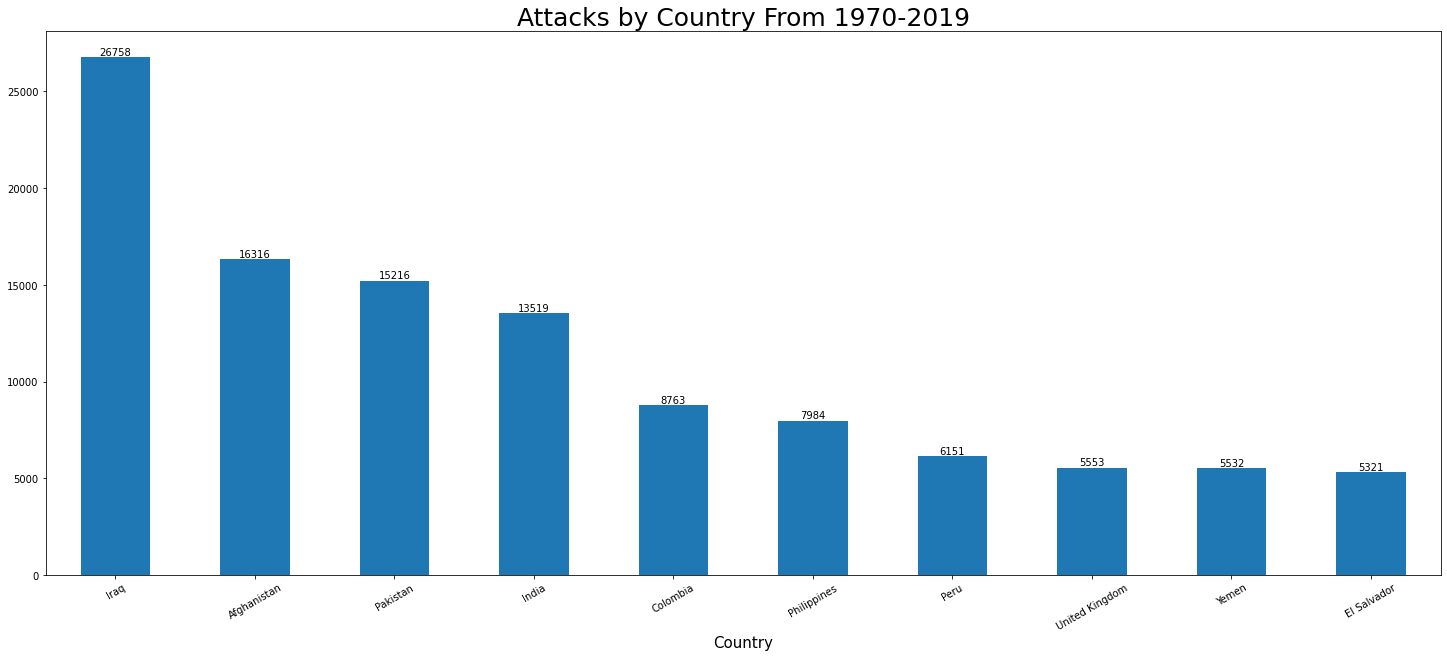

In [10]:
attacks_by_country = raw_data.groupby('Country')\
                             .size()\
                             .sort_values(ascending=False)[0:10]\
                             .plot(kind='bar', figsize=(25, 10), rot=30)
plt.title('Attacks by Country From 1970-2019', fontsize=25)
plt.xlabel('Country', fontsize=15)
plt.bar_label(attacks_by_country.containers[0])
plt.show()


### Attacks grouped by specific terrorist groups

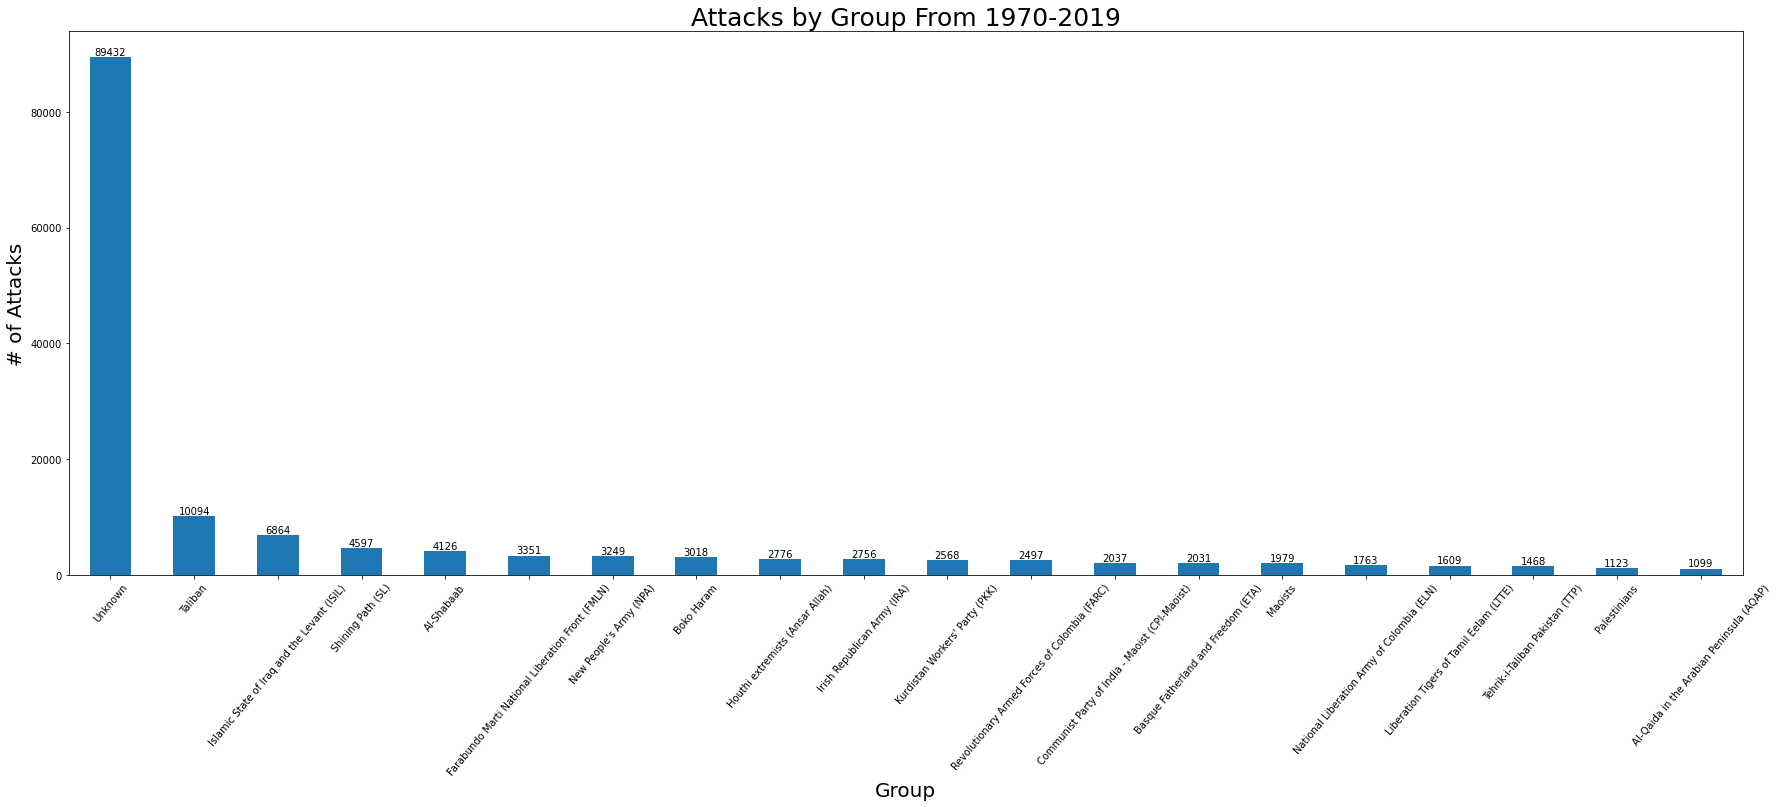

In [11]:
attacks_by_group = raw_data.groupby('gname')\
                           .size()\
                           .sort_values(ascending=False)[0:20]\
                           .plot(kind='bar', rot=50, figsize=(30, 10))
plt.title('Attacks by Group From 1970-2019', fontsize=25)
plt.ylabel("# of Attacks", fontsize=20)
plt.xlabel("Group", fontsize=20)
plt.bar_label(attacks_by_group.containers[0])
plt.show()


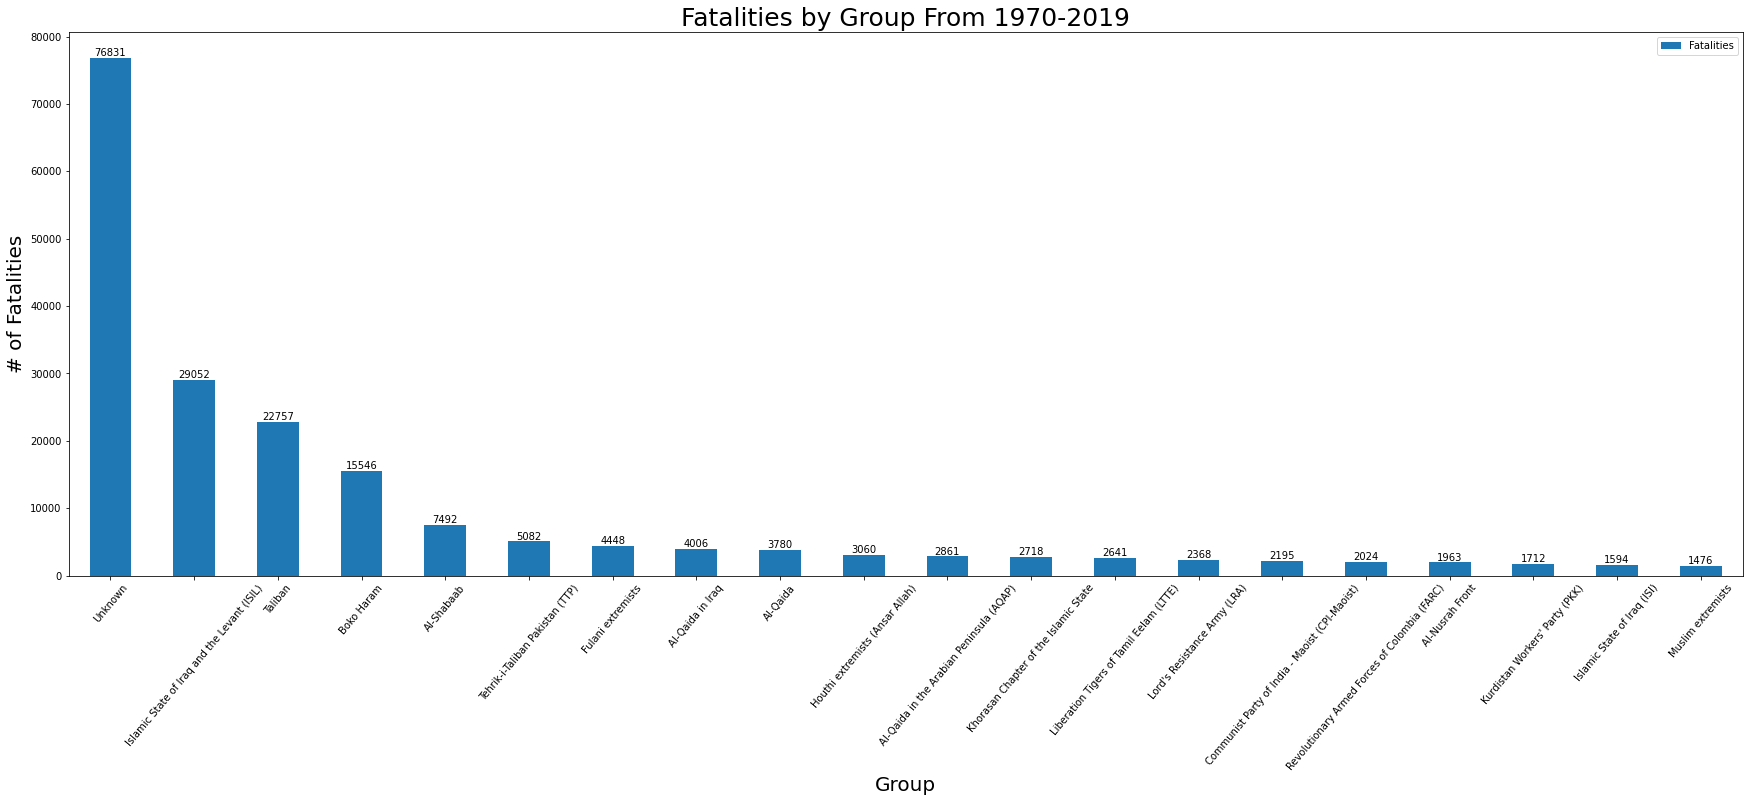

In [12]:
fatalities_by_groups = raw_data[['gname', 'nkill', 'nkillter']]
fatalities_by_groups = fatalities_by_groups.dropna(axis=0, subset=['nkill'])
fatalities_by_groups = fatalities_by_groups.dropna(axis=0, subset=['nkillter'])
fatalities_by_groups['Fatalities'] = fatalities_by_groups['nkill'] - \
    fatalities_by_groups['nkillter']
fatalities_by_groups = fatalities_by_groups.drop(columns=["nkill", 'nkillter'])
graph = fatalities_by_groups.groupby("gname")\
                            .sum().sort_values(by=['Fatalities'], ascending=False)[0:20]\
                            .plot(kind='bar', rot=50, figsize=(30, 10))
plt.title('Fatalities by Group From 1970-2019', fontsize=25)
plt.ylabel("# of Fatalities", fontsize=20)
plt.xlabel("Group", fontsize=20)
plt.bar_label(graph.containers[0])
plt.show()


### Correlation between weapons and outcome

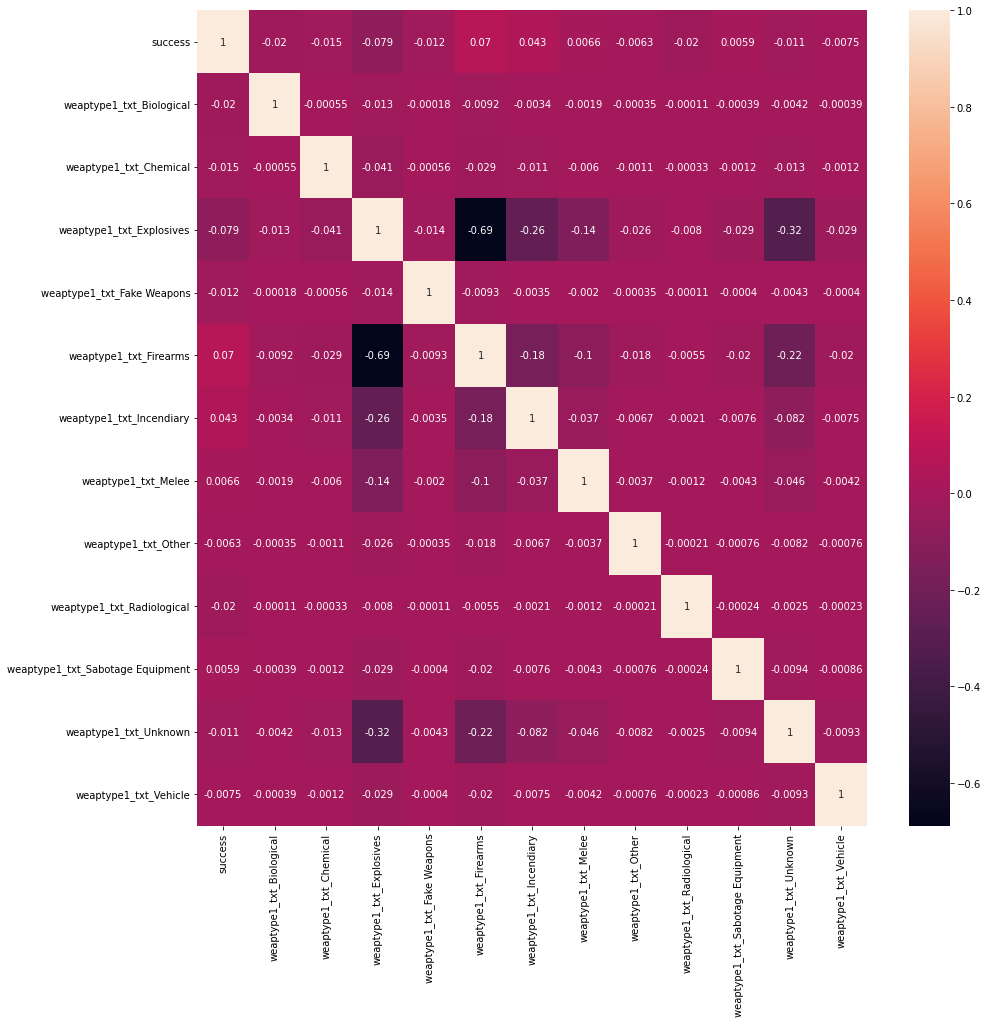

In [13]:
weapon_outcome = pd.get_dummies(raw_data[['weaptype1_txt', 'success']])
weapon_outcome = weapon_outcome.rename(
    columns={'weaptype1_txt_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)': 'weaptype1_txt_Vehicle'})
plt.figure(figsize=(15, 15))
sns.heatmap(weapon_outcome.corr(), annot=True)
plt.show()


It seems that the weapon with most correlation to success is firearms. This makes sense as a firearm can be reloaded and is not single use weapon like a bomb. I will investigate further into the weapon subtype.

In [14]:
weaponsub_outcome = pd.get_dummies(raw_data[['weapsubtype1_txt', 'success']])
weaponsub_outcome.columns


Index(['success', 'weapsubtype1_txt_Arson/Fire',
       'weapsubtype1_txt_Automatic or Semi-Automatic Rifle',
       'weapsubtype1_txt_Blunt Object', 'weapsubtype1_txt_Dynamite/TNT',
       'weapsubtype1_txt_Explosive', 'weapsubtype1_txt_Gasoline or Alcohol',
       'weapsubtype1_txt_Grenade', 'weapsubtype1_txt_Handgun',
       'weapsubtype1_txt_Hands, Feet, Fists',
       'weapsubtype1_txt_Knife or Other Sharp Object',
       'weapsubtype1_txt_Landmine', 'weapsubtype1_txt_Letter Bomb',
       'weapsubtype1_txt_Molotov Cocktail/Petrol Bomb',
       'weapsubtype1_txt_Other Explosive Type',
       'weapsubtype1_txt_Other Gun Type', 'weapsubtype1_txt_Pipe Bomb',
       'weapsubtype1_txt_Poisoning', 'weapsubtype1_txt_Pressure Trigger',
       'weapsubtype1_txt_Projectile (rockets, mortars, RPGs, etc.)',
       'weapsubtype1_txt_Remote Trigger',
       'weapsubtype1_txt_Rifle/Shotgun (non-automatic)',
       'weapsubtype1_txt_Rope or Other Strangling Device',
       'weapsubtype1_txt_Sticky

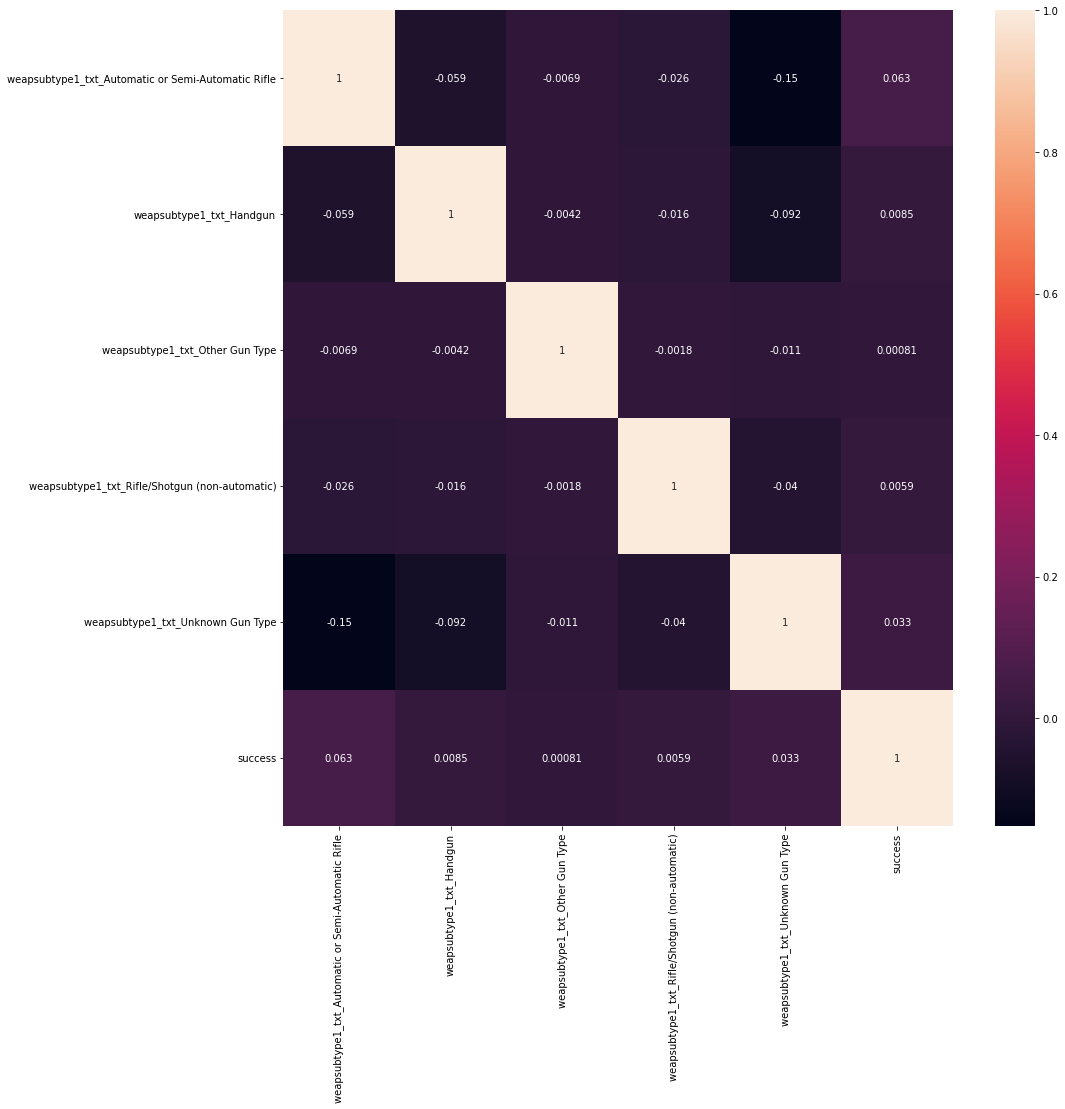

In [15]:
weaponsub_outcome = pd.get_dummies(raw_data[['weapsubtype1_txt', 'success']])
weaponsub_outcome = weaponsub_outcome[['weapsubtype1_txt_Automatic or Semi-Automatic Rifle', 'weapsubtype1_txt_Handgun',
                                       'weapsubtype1_txt_Other Gun Type', 'weapsubtype1_txt_Rifle/Shotgun (non-automatic)',
                                       'weapsubtype1_txt_Unknown Gun Type', 'success']]
plt.figure(figsize=(15, 15))
sns.heatmap(weaponsub_outcome.corr(), annot=True)
plt.show()


The biggest correlation with success is a assault rifle. This makes a lot of sense considering AK47s are all around the world, can be cheaply made and are considered a terrorist's go to weapon. 

## Data filtering and cleaning in preparation for ML models

Now that the data has been loaded, I prepare it for PCA by dropping null values as well as extraneous categorical values. On top of this, I will only use data from 2017-2019 as I only want to work with ML models of active terrorist groups. For necessary categorical values, one hot encoding will be used.

In [2]:
active_data = raw_data[raw_data["Year"] >= 2017]
# filtered for only 2017-2019 data
active_data.columns[active_data.isnull().any()]
# Finding nulls


Index(['approxdate', 'resolution', 'latitude', 'longitude', 'location',
       'alternative', 'alternative_txt', 'attacktype2', 'attacktype2_txt',
       'attacktype3', 'attacktype3_txt', 'targsubtype1', 'targsubtype1_txt',
       'natlty1', 'natlty1_txt', 'targtype2', 'targtype2_txt', 'targsubtype2',
       'targsubtype2_txt', 'corp2', 'target2', 'natlty2', 'natlty2_txt',
       'targtype3', 'targtype3_txt', 'targsubtype3', 'targsubtype3_txt',
       'corp3', 'target3', 'natlty3', 'natlty3_txt', 'gsubname', 'gname2',
       'gsubname2', 'gname3', 'gsubname3', 'motive', 'guncertain2',
       'guncertain3', 'claimmode', 'claimmode_txt', 'claim2', 'claimmode2',
       'claimmode2_txt', 'claim3', 'claimmode3', 'claimmode3_txt', 'compclaim',
       'weapsubtype1', 'weapsubtype1_txt', 'weaptype2', 'weaptype2_txt',
       'weapsubtype2', 'weapsubtype2_txt', 'weaptype3', 'weaptype3_txt',
       'weapsubtype3', 'weapsubtype3_txt', 'weaptype4', 'weaptype4_txt',
       'weapsubtype4', 'weapsubty

In [3]:
# location is important, but I will be dropping categorical columns for location such as country_txt and provstate
# According to the data, there are 137 entries without long/lat
# I am choosing to drop these events as location is important and I want to keep it in the dataset as I'm planning to use dropna
active_data = active_data.dropna(axis=0, subset=['latitude', 'longitude'])
active_data = active_data.dropna(axis=1)
active_data = active_data.drop(columns=['Country', 'region_txt', 'provstate', 'city',  'attacktype1_txt', 'targtype1_txt',
                                        'summary', 'eventid', 'corp1', 'target1', 'weaptype1_txt', 'scite1', 'dbsource'])
# gname is the only one left that is a string but is the crux of this dataset as this is the variable for the terror group name
# I shall now drop it from the dataset and run PCA
groups = active_data[["gname"]]
active_data = active_data.drop(columns=['gname'])
scale = StandardScaler()
active_data_std = pd.DataFrame(scale.fit_transform(active_data))
pca = PCA(n_components=0.95)
active_data_reduced = pca.fit_transform(active_data_std)
num_components = pca.n_components_
# The PCA has been executed and now I build the dataset with only the extremely important features
most_important_index = []
for i in range(num_components):
    most_important_index.append(np.abs(pca.components_[i]).argmax())
most_important_index.sort()
arr = np.array(most_important_index)
most_important_index = np.unique(arr)
# The unique is utilzed due to some duplicates for the principal components

most_important_features = []
for i in most_important_index:
    most_important_features.append(active_data.columns[i])
print("\nMost important features")
active_data[most_important_features]



Most important features


,Year,Month,Day,extended,Region Code,latitude,crit1,crit2,doubtterr,multiple,success,targtype1,individual,nperpcap,claimed,weaptype1,property,ishostkid,INT_IDEO
171003,2017,1,2,1,6,31.318496,1,1,0,0,1.0,1,0,0.0,0.0,5,0,1.0,0
171361,2017,1,3,0,11,12.921007,1,1,0,0,1.0,14,0,0.0,0.0,5,1,0.0,-9
171392,2017,1,1,0,11,1.452372,1,1,0,1,1.0,14,0,0.0,0.0,9,0,0.0,1
171393,2017,1,1,0,11,1.452370,1,1,0,1,1.0,14,0,0.0,0.0,9,0,0.0,1
171493,2017,1,1,0,10,41.106178,1,1,0,0,1.0,1,0,1.0,1.0,5,1,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201178,2019,12,31,0,10,33.303567,1,1,0,0,1.0,14,0,0.0,0.0,6,1,0.0,-9
201179,2019,12,31,0,11,13.440886,1,1,0,0,1.0,3,0,0.0,0.0,13,1,0.0,-9
201180,2019,12,31,0,11,13.440886,1,1,0,0,1.0,2,0,0.0,0.0,5,1,0.0,-9
201181,2019,12,31,0,6,33.812790,1,1,0,0,1.0,14,0,0.0,0.0,6,0,0.0,-9


In [4]:
# Based on this preprocessing, I will create a function that allows me to fetch data for the classifer based on the years needed.
def classifier_cleaner(start_year, end_year):
    df = raw_data[raw_data["Year"].isin([i for i in range(start_year, end_year+1)])]
    df = df.dropna(axis=0, subset=['latitude', 'longitude'])
    df = df.dropna(axis=1)
    groups = df[["gname"]]
    df = df.drop(columns=['gname'])
    X = df[most_important_features]
    le = LabelEncoder()
    y = le.fit_transform(groups)
    X_train,  X_test,  y_train,  y_test = train_test_split(X, y, random_state=42)
    y_train = pd.DataFrame(y_train)
    y_test = pd.DataFrame(y_test)
    return X_train,  X_test,  y_train,  y_test

In [5]:
X_train,  X_test,  y_train,  y_test = classifier_cleaner(2017, 2019)

## Classification

Now that the PCA has been executed and dimensions have been reduced, the dataset is ready for classification.

### Random Forest

In [4]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)

accuracy_score(y_test, pred)


0.8695357964541887

In [37]:
# coarse
param_grid = [
    {'n_estimators': [10, 100, 150, 200],
     'max_depth':[1, 16, 32]
     }]
grid_search_rfc = GridSearchCV(rfc, param_grid, cv=3, n_jobs=-1)
grid_search_rfc.fit(X_train, y_train)
grid_search_rfc.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 3min 27s


{'max_depth': 32, 'n_estimators': 150}

In [31]:
# more refined
param_grid = [
    {'n_estimators': [125, 150, 175],
     'max_depth':[24, 32, 40, 48]
     }]
grid_search_rfc = GridSearchCV(rfc, param_grid, cv=3, n_jobs=-1)
grid_search_rfc.fit(X_train, y_train)
grid_search_rfc.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 20min 56s


{'max_depth': 24, 'min_samples_split': 3, 'n_estimators': 150}

In [32]:
# even more refined
param_grid = [
    {'n_estimators': [140, 150, 160],
     'max_depth':[22, 24, 26, 28]
     }]
grid_search_rfc = GridSearchCV(rfc, param_grid, cv=3, n_jobs=-1)
grid_search_rfc.fit(X_train, y_train)
grid_search_rfc.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 15min 16s


{'max_depth': 28, 'min_samples_split': 2, 'n_estimators': 150}

In [18]:
final_rfc = RandomForestClassifier(
    random_state=42, n_jobs=-1, max_depth=28, min_samples_split=2, n_estimators=150)
final_rfc.fit(X_train, y_train)
pred = final_rfc.predict(X_test)

accuracy_score(y_test, pred)


0.8706184869400461

Barely any improvement but still pretty decent accuracy. Next up is AdaBoost

### AdaBoost

In [22]:
from sklearn.ensemble import AdaBoostClassifier
Ada = AdaBoostClassifier(random_state=42)
Ada.fit(X_train, y_train)
pred = Ada.predict(X_test)
accuracy_score(y_test, pred)


0.48287995669238054

Much worse but I took a look at the results and it actually works even though the predictions are off. I will now try to fine tune the hyperparameters

In [35]:
# coarse
param_grid = [
    {'n_estimators': [50, 100, 150, 200],
     'learning_rate':[0.25, 0.5, 0.75, 1, 1.25]
     }]
grid_search_ada = GridSearchCV(Ada, param_grid, cv=3, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)
grid_search_ada.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 8min 56s


{'learning_rate': 0.25, 'n_estimators': 100}

In [36]:
# more refined
param_grid = [
    {'n_estimators': [75, 100, 125],
     'learning_rate': [0.1, 0.2, 0.3]
     }]
grid_search_ada = GridSearchCV(Ada, param_grid, cv=3, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)
grid_search_ada.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 3min 37s


{'learning_rate': 0.1, 'n_estimators': 75}

In [37]:
# even more refined
param_grid = [
    {'n_estimators': [75, 80, 85, 90, 95, 100],
     'learning_rate':[0.05, 0.01, 0.15, 0.2]
     }]
grid_search_ada = GridSearchCV(Ada, param_grid, cv=3, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)
grid_search_ada.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 7min 36s


{'learning_rate': 0.05, 'n_estimators': 95}

In [23]:
final_Ada = AdaBoostClassifier(random_state=42, learning_rate=0.05, n_estimators=95)
final_Ada.fit(X_train, y_train)
pred = final_Ada.predict(X_test)

accuracy_score(y_test, pred)


0.7042901610502098

Optimization went well but Random Forest still beats AdaBoost by a long shot. Next up is XGBoost.

### XGBoost

In [38]:
xgb = xgboost.XGBClassifier(random_state=42, n_jobs=-1, eval_metric='merror')
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)
xgb.fit(X_train_scale, y_train)
pred = xgb.predict(X_test_scale)
accuracy_score(y_test, pred)


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



0.7088915956151035

This is close to the fully optimized AdaBoost. This classifier may or may not beat out the Random Forest.

In [32]:
# coarse
param_grid = [
    {'n_estimators': [50, 100, 150],
     'max_depth':[1, 5, 10],
     'learning_rate':[0.05, 0.1, 0.3, 0.6]
     }]
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train_scale, y_train)
grid_search_xgb.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



In [58]:
# more refined
param_grid = [
    {'n_estimators': [125, 150, 200, 300],
     'max_depth':[8, 10, 16, 24],
     'learning_rate':[0.01, 0.025, 0.05, 0.075]
     }]
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train_scale, y_train)
grid_search_xgb.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[16:52:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5h 6min 44s


{'learning_rate': 0.025, 'max_depth': 24, 'n_estimators': 300}

In [59]:
# even more refined
param_grid = [
    {'n_estimators': [300, 400, 500],
     'max_depth':[24, 32, 40, 48],
     'learning_rate':[0.01, 0.02, 0.025, 0.03]
     }]
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=3, n_jobs=-1)
grid_search_xgb.fit(X_train_scale, y_train)
grid_search_xgb.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:666: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[00:55:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 8h 1min 6s


{'learning_rate': 0.02, 'max_depth': 24, 'n_estimators': 400}

In [39]:
final_xgb = xgboost.XGBClassifier(
    random_state=42, n_jobs=-1, eval_metric='merror', learning_rate=0.02, max_depth=24, n_estimators=400)
final_xgb.fit(X_train_scale, y_train)
pred = final_xgb.predict(X_test_scale)
accuracy_score(y_test, pred)


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



0.8788740018947083

This actually beat Random Forest by just a bit. I will try giving Artifical Neural Networks a shot.

### Artificial Neural Network

In [57]:
model = keras.models.Sequential([
    keras.layers.Dense(19, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(547, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.0001))
model.fit(X_train_scale, y_train, epochs=200, verbose=0)
pred_ann = np.argmax(model.predict(X_test_scale), axis=1) 
accuracy_score(y_test, pred_ann)


0.7055081878467993

Let's try to fine tune the hyperparameters. In order to do this, a dummy keras model needs to be custom defined and built first

In [6]:
def build_model(n_neurons, n_hidden, learning_rate):
    dummy = keras.models.Sequential()
    dummy.add(keras.layers.InputLayer(input_shape=19))
    for layer in range(1, n_hidden+1):
        dummy.add(keras.layers.Dense(n_neurons, activation="relu"))
    dummy.add(keras.layers.Dense(547, activation="softmax"))
    dummy.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.Adam(
        learning_rate=learning_rate), metrics=['accuracy'])
    return dummy


In [7]:
from scikeras.wrappers import KerasClassifier
test_model = KerasClassifier(build_model, loss="sparse_categorical_crossentropy",
                             n_hidden=3, n_neurons=50, learning_rate=0.0001)


In [11]:
# coarse
param_grid = [
    {'n_hidden': [3, 4, 5],
     'n_neurons':[50, 100, 150],
     'learning_rate':[0.000075, 0.0001, 0.000125, 0.000150]
     }]
grid_search_ann = GridSearchCV(test_model, param_grid, cv=3, n_jobs=1)
grid_search_ann.fit(X_train_scale, y_train, epochs=100, verbose=0)
grid_search_ann.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



231/231 [==============================] - 0s 703us/step


{'learning_rate': 0.00015, 'n_hidden': 3, 'n_neurons': 150}

In [48]:
# more refined
param_grid = [
    {'n_hidden': [2, 3, 4],
     'n_neurons':[125, 150, 175, 200],
     'learning_rate':[0.00015, 0.0002, 0.00025, 0.0003]
     }]
grid_search_ann = GridSearchCV(test_model, param_grid, cv=3, n_jobs=-1)
grid_search_ann.fit(X_train_scale, y_train, epochs=100, verbose=0)
grid_search_ann.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



{'learning_rate': 0.0003, 'n_hidden': 4, 'n_neurons': 200}

In [58]:
# even more refined
param_grid = [
    {'n_hidden': [3, 4, 5],
     'n_neurons':[200, 225, 250, 275, 300],
     'learning_rate':[0.00025, 0.0003, 0.00035, 0.0004]
     }]
grid_search_ann = GridSearchCV(test_model, param_grid, cv=3, n_jobs=-1)
grid_search_ann.fit(X_train_scale, y_train, epochs=100, verbose=0)
grid_search_ann.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



{'learning_rate': 0.0004, 'n_hidden': 5, 'n_neurons': 275}

In [6]:
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

In [7]:
final_ann = keras.models.Sequential([
    keras.layers.Dense(19, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(275, activation="relu"),
    keras.layers.Dense(275, activation="relu"),
    keras.layers.Dense(275, activation="relu"),
    keras.layers.Dense(275, activation="relu"),
    keras.layers.Dense(275, activation="relu"),
    keras.layers.Dense(547, activation="softmax")
])
final_ann.compile(loss="sparse_categorical_crossentropy",
               optimizer=keras.optimizers.Adam(learning_rate=0.0004))
final_ann.fit(X_train_scale, y_train, epochs=200, verbose=0)
pred_final_ann = np.argmax(final_ann.predict(X_test_scale), axis=1) 
accuracy_score(y_test, pred_final_ann)

231/231 [==============================] - 0s 1ms/step


0.804303694681283

Performance is better. XGBoost beats all of these.

## Further Data cleaning and reclassification

After further consideration and deliberation, the next step is to drop the "Unknown" events from the dataset and see how that impacts accuracy. 

In [18]:
index_of_unknowns = []
for i in groups.index:
    if groups["gname"][i] == 'Unknown':
        index_of_unknowns.append(i)
# gwou is groups without unknowns and adwou is active_data without unknowns
adwou = active_data.drop(index_of_unknowns)
gwou = groups.drop(index_of_unknowns)
X = adwou[most_important_features]
y = gwou
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


### Random Forest Classifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(X_train, y_train)
pred = rfc.predict(X_test)

accuracy_score(y_test, pred)


0.8479744136460554

In [20]:
# coarse
param_grid = [
    {'n_estimators': [10, 100, 150, 200],
     'max_depth':[1, 16, 32],
     'min_samples_split':[2, 10, 20]
     }]
grid_search_rfc = GridSearchCV(rfc, param_grid, cv=3, n_jobs=-1)
grid_search_rfc.fit(X_train, y_train)
grid_search_rfc.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 2min 9s


{'max_depth': 32, 'min_samples_split': 2, 'n_estimators': 200}

In [21]:
# more refined
param_grid = [
    {'n_estimators': [175, 200, 250],
     'max_depth':[24, 32, 40, 48],
     'min_samples_split':[2, 3, 4, 5, 6]
     }]
grid_search_rfc = GridSearchCV(rfc, param_grid, cv=3, n_jobs=-1)
grid_search_rfc.fit(X_train, y_train)
grid_search_rfc.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 23min 24s


{'max_depth': 24, 'min_samples_split': 3, 'n_estimators': 200}

In [22]:
# even more refined
param_grid = [
    {'n_estimators': [190, 200, 210],
     'max_depth':[20, 22, 24, 28],
     'min_samples_split':[2, 3, 4]
     }]
grid_search_rfc = GridSearchCV(rfc, param_grid, cv=3, n_jobs=-1)
grid_search_rfc.fit(X_train, y_train)
grid_search_rfc.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 20min 4s


{'max_depth': 24, 'min_samples_split': 3, 'n_estimators': 200}

In [23]:
final_rfc = RandomForestClassifier(
    random_state=42, n_jobs=-1, **grid_search_rfc.best_params_)
final_rfc.fit(X_train, y_train)
pred = final_rfc.predict(X_test)

accuracy_score(y_test, pred)


0.8464818763326226

It seems that the hypertuning has resulted in slightly worse accuracy for the Random Forest Classifier. It also seems that removing the "Unknowns" has also affected the accuracy as the Random Forest Classifier with the unknowns actually runs with higher accuracy. There was a large amount of relevant data in the rows of the "Unknown" entries that has now been dropped. Let's see if this trend continues.

### AdaBoost

In [24]:
Ada = AdaBoostClassifier(random_state=42)
Ada.fit(X_train, y_train)
pred = Ada.predict(X_test)
accuracy_score(y_test, pred)


Wall time: 14.3 s


0.28912579957356077

This is close to half as much worse than the original. Let's try to hypertune.

In [25]:
# coarse
param_grid = [
    {'n_estimators': [50, 100, 150, 200],
     'learning_rate':[0.25, 0.5, 0.75, 1, 1.25]
     }]
grid_search_ada = GridSearchCV(Ada, param_grid, cv=3, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)
grid_search_ada.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 6min 14s


{'learning_rate': 0.5, 'n_estimators': 200}

In [26]:
# more refined
param_grid = [
    {'n_estimators': [175, 200, 250, 300, 350, 400],
     'learning_rate':[0.3, 0.4, 0.5, 0.6, 0.7]
     }]
grid_search_ada = GridSearchCV(Ada, param_grid, cv=3, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)
grid_search_ada.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 19min 34s


{'learning_rate': 0.6, 'n_estimators': 400}

In [27]:
# even more refined
param_grid = [
    {'n_estimators': [350, 400, 450, 500],
     'learning_rate':[0.55, 0.6, 0.65, 0.7]
     }]
grid_search_ada = GridSearchCV(Ada, param_grid, cv=3, n_jobs=-1)
grid_search_ada.fit(X_train, y_train)
grid_search_ada.best_params_


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



Wall time: 16min 41s


{'learning_rate': 0.6, 'n_estimators': 500}

In [28]:
final_Ada = AdaBoostClassifier(random_state=42, **grid_search_ada.best_params_)
final_Ada.fit(X_train, y_train)
pred = final_Ada.predict(X_test)

accuracy_score(y_test, pred)


0.5537313432835821

The accuracy has nearly doubled but this is much worse than the inital AdaBoost with the "Unknowns" in the data. No point to run more classifiers and I will go back to using the original active_data and groups. The hypertuned XGBoost seems to be the best one to use. However, additional investigation into other metrics is warranted for each of the models. 

In [42]:
X_train,  X_test,  y_train,  y_test = classifier_cleaner(2017, 2019)
# I set my final classifier as the hypertuned XGBClassifier as it was the one with the best performance
classifier = xgboost.XGBClassifier(
    random_state=42, n_jobs=-1, learning_rate=0.02, max_depth=24, eval_metric='merror', n_estimators=400)
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)
classifier.fit(X_train_scale, y_train)
pred = classifier.predict(X_test_scale)
accuracy_score(y_test, pred)

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



0.8788740018947083

In [ ]:
def evaluate_model(model, X_test, y_test, X_train, y_train):
    pred = model.predict(X_test)
    
    print(f"K-folds Cross Validation across 10 folds: \n {cross_val_score(model, X_train, y_train, cv=10, n_jobs=1, scoring='accuracy')}")
    print(f'Accuracy Score: {accuracy_score(y_test, pred)}')    
    print(f"Matthew's corrrelation score: {matthews_corrcoef(y_test, pred)}" )
    print(classification_report(y_test, pred, zero_division=0))

In [32]:
evaluate_model(final_rfc, X_test, y_test, X_train, y_train)

Accuracy Score: 0.8706184869400461


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



K-folds Cross Validation across 10 folds: 
 [0.88858818 0.87009472 0.87911592 0.87550744 0.87776274 0.87280108
 0.87325214 0.87545126 0.87906137 0.88176895]
Matthew's corrrelation score: 0.843547733119472
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.83      0.69      0.75        29
           4       1.00      0.50      0.67         2
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00     

In [34]:
evaluate_model(final_Ada, X_test, y_test, X_train, y_train)

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



K-folds Cross Validation across 10 folds: 
 [0.70816419 0.70771313 0.70545783 0.70681101 0.70545783 0.70681101
 0.70455571 0.70532491 0.71119134 0.70983755]
Accuracy Score: 0.7042901610502098
Matthew's corrrelation score: 0.6376142365590343
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
  

In [56]:
evaluate_model(classifier, X_test_scale, y_test, X_train_scale, y_train)

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 

K-folds Cross Validation across 10 folds: 
 [0.887235   0.8827244  0.88678394 0.88768606 0.88768606 0.8804691
 0.87776274 0.88944043 0.88673285 0.89575812]
Accuracy Score: 0.8788740018947083
Matthew's corrrelation score: 0.8538858044173676
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.72      0.90      0.80        29
           4       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
   

In [ ]:
final_ann_eval = KerasClassifier(final_ann)
print(f'Accuracy Score: {accuracy_score(y_test, pred_final_ann)}')    
print(f"Matthew's corrrelation score: {matthews_corrcoef(y_test, pred_final_ann)}" )
print(classification_report(y_test, pred_final_ann, zero_division=0))
ann_cross_val = cross_val_score(final_ann_eval, X_train, y_train, cv=10, n_jobs=1, scoring='accuracy', verbose=0)
print(f"K-folds Cross Validation across 10 folds: \n {ann_cross_val}")

Accuracy Score: 0.807551766138855
Matthew's corrrelation score: 0.7662785863256365
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        29
           4       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         1
          20       0.00      0.00      0.00         6
          23       0.63      0.63      0.63        19
          25       0.00      0.00      0.00         

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpskjfbybl\assets
70/70 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc12hwaw5\assets
70/70 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpz0cx53rc\assets
70/70 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxdnil4or\assets
70/70 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpmryg1cmt\assets
70/70 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp29h74914\assets
70/70 [==============================] - 0s 1ms/step
INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd93fob8j\assets
70/70 [==============================] - 0s 1ms/step

## Classifier by region

The data will be split based on the regions where events took place. Then, these mini-datasets will be classified.

In [16]:
le = LabelEncoder()
le.fit_transform(groups)
region = {i: active_data[active_data['Region Code'] == i] for i in range(1, 13)}
groups_by_region = {i: le.transform(groups.loc[region[i].index.tolist()]) for i in region}

def regional_classifier(i):
    X_train_dummy, X_test_dummy, y_train_dummy, y_test_dummy = train_test_split(
        region[i], groups_by_region[i], random_state=42)
    X_train_scale = scale.fit_transform(X_train_dummy)
    X_test_scale = scale.transform(X_test_dummy)
    classifier.fit(X_train_scale, y_train_dummy)
    pred = classifier.predict(X_test_scale)
    return accuracy_score(y_test_dummy, pred)
    
acc = []
for i in range(1, 13):
    acc.append(regional_classifier(i))

for i in range(0, 12):
    print(f'Region {i+1}: {acc[i]}')
    if acc[i] > 0.878:
        print("This is better than the general prediction")

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will b

Region 1: 0.6582278481012658
Region 2: 0.8888888888888888
This is better than the general prediction
Region 3: 0.8279569892473119
Region 4: 0.875
Region 5: 0.9402756508422665
This is better than the general prediction
Region 6: 0.9412489728841413
This is better than the general prediction
Region 7: 0.0
Region 8: 0.7413793103448276
Region 9: 0.8771929824561403
Region 10: 0.9418811002661934
This is better than the general prediction
Region 11: 0.9042622950819672
This is better than the general prediction
Region 12: 0.8


Regions 2, 5, 6, 10 and 11 improved by this individual region classification. Region 7 is the only one that failed abysmally. Let's look at the attacks by region analysis again to extract some insights.

In [17]:
for i in region:
    print("Region", i, ":", len(region[i]), "attacks")


Region 1 : 315 attacks
Region 2 : 34 attacks
Region 3 : 741 attacks
Region 4 : 30 attacks
Region 5 : 2609 attacks
Region 6 : 9735 attacks
Region 7 : 18 attacks
Region 8 : 693 attacks
Region 9 : 228 attacks
Region 10 : 9015 attacks
Region 11 : 6099 attacks
Region 12 : 39 attacks


Regions 5, 6 and 10 correspond to Southeast Asia, South Asia and Middle East/North Africa. The cases of regions 5, 6 and 10 make sense as there is a plethora of events and data to learn from. Region 7 makes sense as it has the least number of attacks/data to learn from. This makes sense given the trend of good accuracy being associated with data rich datasets. For regions 2 and 11, which are Central America/Carribean and Australasia & Oceania, they had low numbers but high accuracy, which indicates a confounding factor of perhaps closely grouped attacks with very similar features. 

### Raw Data?

Let's try using the data before the PCA and see what results that yields.

In [9]:
active_data = raw_data[raw_data["Year"] >= 2017]
active_data = active_data.dropna(axis=0, subset=['latitude'])
active_data = active_data.dropna(axis=1)
active_data = active_data.drop(columns=['Country', 'region_txt', 'provstate', 'city', 'attacktype1_txt', 'targtype1_txt',
                                        'summary', 'eventid', 'corp1', 'target1', 'weaptype1_txt', 'scite1', 'dbsource'])
groups = active_data[["gname"]]
active_data = active_data.drop(columns=['gname'])

X = active_data
y = groups
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
# I set my final classifier as the hypertuned XGBoost classifier as it was the one with the best performance
classifier = xgboost.XGBClassifier(
    random_state=42, n_jobs=-1, learning_rate=0.02, max_depth=24, eval_metric='merror', n_estimators=400)
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)
classifier.fit(X_train_scale, y_train)
pred = classifier.predict(X_test_scale)
accuracy_score(y_test, pred)


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



0.9133847611314115

A 3.5% increase is yielded with the data before the PCA. 

Let's see how well this generalizes. I will use a different subset of years to train and test this classifier.

In [11]:
X_train, X_test, y_train, y_test = classifier_cleaner(2014, 2016)
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)
classifier.fit(X_train_scale, y_train)
pred = classifier.predict(X_test_scale)
accuracy_score(y_test, pred)


C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



0.9353910541459587

The accuracy actually went up by a good 2%. This shows good generalization. I will apply this classifier to every year and graph the accuracy.

In [12]:
years = [i for i in range(1970, 2020)]
accuracy = []
for i in range(1970, 2020):
    active_data = raw_data[raw_data["Year"] == i]
    if (i != 1993):
        active_data = active_data.dropna(axis=0, subset=['latitude'])
    active_data = active_data.drop(columns=['Country', 'region_txt', 'provstate', 'city',
                                            'attacktype1_txt', 'targtype1_txt', 'summary',
                                            'natlty1_txt', 'eventid', 'corp1', 'target1', 'weaptype1_txt',
                                            'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource'])
    active_data = active_data.dropna(axis=1)
    groups = active_data[["gname"]]
    active_data = active_data.drop(columns=['gname'])
    X = active_data
    y = groups
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    X_train_scale = scale.fit_transform(X_train)
    X_test_scale = scale.transform(X_test)
    classifier.fit(X_train_scale, y_train)
    pred = classifier.predict(X_test_scale)
    accuracy.append(accuracy_score(y_test, pred))

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].

C:\Users\Nasibul\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will b

Accuracy for 1970 is 0.7018633540372671
Accuracy for 1971 is 0.6637931034482759
Accuracy for 1972 is 0.6884057971014492
Accuracy for 1973 is 0.7863247863247863
Accuracy for 1974 is 0.6413793103448275
Accuracy for 1975 is 0.6813186813186813
Accuracy for 1976 is 0.7377777777777778
Accuracy for 1977 is 0.8204334365325078
Accuracy for 1978 is 0.7582417582417582
Accuracy for 1979 is 0.8123028391167192
Accuracy for 1980 is 0.80625
Accuracy for 1981 is 0.843042071197411
Accuracy for 1982 is 0.8803986710963455
Accuracy for 1983 is 0.8787425149700598
Accuracy for 1984 is 0.88375
Accuracy for 1985 is 0.8641791044776119
Accuracy for 1986 is 0.8298507462686567
Accuracy for 1987 is 0.8770053475935828
Accuracy for 1988 is 0.869815668202765
Accuracy for 1989 is 0.8813886210221794
Accuracy for 1990 is 0.8782894736842105
Accuracy for 1991 is 0.8502722323049002
Accuracy for 1992 is 0.8354011579818031
Accuracy for 1993 is 0.786096256684492
Accuracy for 1994 is 0.8191747572815534
Accuracy for 1995 is 0.84

<function matplotlib.pyplot.show(close=None, block=None)>

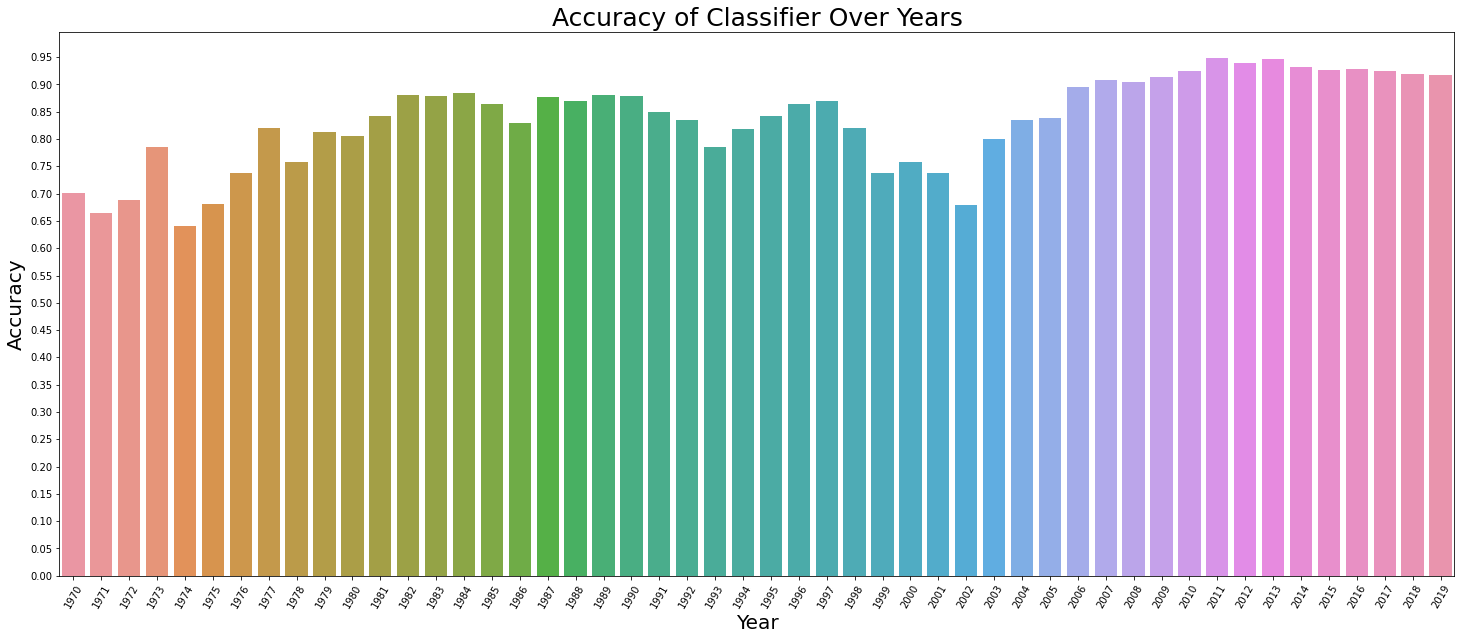

In [14]:
for i in range(0, len(years)):
    print('Accuracy for', years[i], 'is', accuracy[i])
fig = plt.figure(figsize=(25, 10))
ax = sns.barplot(x=years, y=accuracy)
ax.set_title('Accuracy of Classifier Over Years', fontsize=25)
ax.set_ylabel("Accuracy", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
plt.yticks(np.arange(0, 1, 0.05))
plt.xticks(rotation=60)
plt.show


In [19]:
mean(accuracy)


0.8357703421263292

Overall accuracy of the most refined classifier is 0.835. Pretty decent but not amazing.

## Regression

I will now make a ML regressor that can predict the number of casualties and wounded from an attack. This will allow hospitals and medics to have a better guess on what kind or level of medical equipment and supplies are needed or even if medevac or other advanced resources are required. This is a multioutput regressor task as one output is the number of fatalities and the other output is the number of wounded. 

For the nkill variable, the codebook states "This field stores the number of total confirmed fatalities for the incident. The number includes all victims and attackers who died as a direct result of the incident. Where there is evidence of fatalities, but a figure is not reported or it is too vague to be of use, this field remains blank. If information is missing regarding the number of victims killed in an attack, but perpetrator fatalities are known, this value will reflect only the number of perpetrators who died as a result of the incident. Likewise, if information on the number of perpetrators killed in an attack is missing, but victim fatalities are known, this field will only report the number of victims killed in the incident."

Same thing applies for the nwound variable. Therefore, I will make new variables named "Wounded" and "Fatalities" to reflect only injured civilians and civilian fatalities by subtracting the wounded and killed perpetrators.

Each regressor will output the rmse for the two variables. Therefore, the lower the rmse, the better the predictions from the regressor.

### Data Prep for Regression

Going to use the raw data but filtered to exclude the nulls and for only the years 2017-2019. I want to keep the variables nwound, nkill, nkillter and nwoundter as they are critical to figuring out the number of civilian wounded and number of civilian fatalities

In [11]:
def regressor_cleaner(start_year, end_year):
    df = raw_data[raw_data["Year"].isin([i for i in range(start_year, end_year+1)])]
    df = df.dropna(axis=0, subset=['latitude'])
    df = df.dropna(axis=0, subset=['nwound'])
    df = df.dropna(axis=0, subset=['nwoundte'])
    df = df.dropna(axis=0, subset=['nkill'])
    df = df.dropna(axis=0, subset=['nkillter'])
    df = df.dropna(axis=1)
    y = df[['nwound', 'nkill', 'nkillter', 'nwoundte']]
    most_important_features.append('gname')
    y['Fatalities'] = y['nkill'] - y['nkillter']
    y['Wounded'] = y['nwound'] - y['nwoundte']
    y = y.drop(columns=["nkill", 'nkillter', 'nwound', 'nwoundte'])
    X = df[most_important_features]
    X = pd.get_dummies(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test = regressor_cleaner(2017, 2019)

C:\Users\Nasibul\AppData\Local\Temp\ipykernel_3512\395189668.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Nasibul\AppData\Local\Temp\ipykernel_3512\395189668.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Random Forest Regressor

In [12]:
rfr = RandomForestRegressor(random_state=42, n_jobs=-1)
rfr.fit(X_train, y_train)
pred = np.round(rfr.predict(X_test))

mean_squared_error(y_test, pred, multioutput='raw_values', squared=False)


array([ 5.01960918, 12.53457073])

In [13]:
# coarse
param_grid = [
    {'n_estimators': [10, 100, 150, 200],
     'max_depth':[1, 16, 32],
     'min_samples_split':[2, 10, 20]
     }]
grid_search_rfr = GridSearchCV(rfr, param_grid, cv=3, n_jobs=-1)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_


{'max_depth': 32, 'min_samples_split': 20, 'n_estimators': 200}

In [15]:
# more refined
param_grid = [
    {'n_estimators': [175, 200, 225, 250],
     'max_depth':[24, 32, 48, 64],
     'min_samples_split':[15, 20, 25, 30]
     }]
grid_search_rfr = GridSearchCV(rfr, param_grid, cv=3, n_jobs=-1)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_


{'max_depth': 64, 'min_samples_split': 30, 'n_estimators': 250}

In [16]:
# even more refined
param_grid = [
    {'n_estimators': [235, 250, 275, 300],
     'max_depth':[54, 64, 96, 128],
     'min_samples_split':[25, 30, 35, 40, 45]
     }]
grid_search_rfr = GridSearchCV(rfr, param_grid, cv=3, n_jobs=-1)
grid_search_rfr.fit(X_train, y_train)
grid_search_rfr.best_params_


{'max_depth': 64, 'min_samples_split': 45, 'n_estimators': 275}

In [17]:
final_rfr = RandomForestRegressor(
    random_state=42, n_jobs=-1, **grid_search_rfr.best_params_)
final_rfr.fit(X_train, y_train)
pred = final_rfr.predict(X_test)

mean_squared_error(y_test, pred, multioutput='raw_values', squared=False)


array([ 4.0563893 , 12.51623175])

### AdaBoostRegressor

In [18]:
Adar = AdaBoostRegressor(random_state=42)
wrapper_ada = MultiOutputRegressor(Adar)
wrapper_ada.fit(X_train, y_train)
pred = wrapper_ada.predict(X_test)
mean_squared_error(y_test, pred, multioutput='raw_values', squared=False)


array([16.29849796, 14.71192677])

In [19]:
# coarse
param_grid = [
    {'estimator__n_estimators': [50, 100, 150, 200],
     'estimator__learning_rate':[0.25, 0.5, 0.75, 1, 1.25]
     }]
grid_search_adar = GridSearchCV(wrapper_ada, param_grid, cv=3, n_jobs=-1)
grid_search_adar.fit(X_train, y_train)
grid_search_adar.best_params_


{'estimator__learning_rate': 0.25, 'estimator__n_estimators': 50}

In [20]:
# more refined
param_grid = [
    {'estimator__n_estimators': [25, 50, 75],
     'estimator__learning_rate':[0.1, 0.2, 0.25, 0.3, 0.4]
     }]
grid_search_adar = GridSearchCV(wrapper_ada, param_grid, cv=3, n_jobs=-1)
grid_search_adar.fit(X_train, y_train)
grid_search_adar.best_params_


{'estimator__learning_rate': 0.1, 'estimator__n_estimators': 50}

In [22]:
# even more refined
param_grid = [
    {'estimator__n_estimators': [40, 50, 60],
     'estimator__learning_rate':[0.05, 0.1, 0.15]
     }]
grid_search_adar = GridSearchCV(wrapper_ada, param_grid, cv=3, n_jobs=-1)
grid_search_adar.fit(X_train, y_train)
grid_search_adar.best_params_


{'estimator__learning_rate': 0.1, 'estimator__n_estimators': 50}

In [25]:
final_Adar = AdaBoostRegressor(
    random_state=42, learning_rate=0.1, n_estimators=50)
final_wrapper_ada = MultiOutputRegressor(final_Adar)
final_wrapper_ada.fit(X_train, y_train)
pred = final_wrapper_ada.predict(X_test)
mean_squared_error(y_test, pred, multioutput='raw_values', squared=False)


array([ 7.11895635, 13.15845138])

### XGBRegressor

In [6]:
scale = StandardScaler()
X_train_scale = scale.fit_transform(X_train)
X_test_scale = scale.transform(X_test)

In [5]:
XGBr = xgboost.XGBRegressor(random_state=42, n_jobs=-1)
wrapper_xgb = MultiOutputRegressor(XGBr)
wrapper_xgb.fit(X_train_scale, y_train)
pred = wrapper_xgb.predict(X_test_scale)
mean_squared_error(y_test, pred, multioutput='raw_values', squared=False)


array([ 6.66479082, 12.6572205 ])

In [27]:
# coarse
param_grid = [
    {'estimator__n_estimators': [50, 100, 150],
     'estimator__max_depth':[1, 5, 10],
     'estimator__learning_rate':[0.05, 0.1, 0.3, 0.6]
     }]
grid_search_xgbr = GridSearchCV(wrapper_xgb, param_grid, cv=3, n_jobs=-1)
grid_search_xgbr.fit(X_train_scale, y_train)
grid_search_xgbr.best_params_


{'estimator__learning_rate': 0.6,
 'estimator__max_depth': 1,
 'estimator__n_estimators': 50}

In [28]:
# more refined
param_grid = [
    {'estimator__n_estimators': [25, 35, 50, 65, 75],
     'estimator__max_depth':[1, 2, 3],
     'estimator__learning_rate':[0.5, 0.6, 0.7, 0.75, 0.8, 0.9]
     }]
grid_search_xgbr = GridSearchCV(wrapper_xgb, param_grid, cv=3, n_jobs=-1)
grid_search_xgbr.fit(X_train_scale, y_train)
grid_search_xgbr.best_params_


{'estimator__learning_rate': 0.8,
 'estimator__max_depth': 1,
 'estimator__n_estimators': 75}

In [29]:
# even more refined
param_grid = [
    {'estimator__n_estimators': [75, 85, 95],
     'estimator__learning_rate':[0.75, 0.775, 0.8, 0.85]
     }]
grid_search_xgbr = GridSearchCV(wrapper_xgb, param_grid, cv=3, n_jobs=-1)
grid_search_xgbr.fit(X_train_scale, y_train)
grid_search_xgbr.best_params_


{'estimator__learning_rate': 0.8, 'estimator__n_estimators': 75}

In [31]:
final_XGBr = xgboost.XGBRegressor(
    random_state=42, n_jobs=-1, learning_rate=0.9, max_depth=1, n_estimators=75)
final_wrapper_xgb = MultiOutputRegressor(final_XGBr)
final_wrapper_xgb.fit(X_train_scale, y_train)
pred = final_wrapper_xgb.predict(X_test_scale)
mean_squared_error(y_test, pred, multioutput='raw_values', squared=False)


array([ 4.1452937 , 12.62677945])

### Artificial Neural Network

In [6]:
X_train_scale.shape

(19069, 523)

In [25]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=10, min_delta=0.1)
model = keras.models.Sequential([
    keras.layers.Dense(523, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(2)
])
model.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(),
              metrics=keras.metrics.RootMeanSquaredError())
model.fit(X_train_scale, y_train, epochs=200, verbose=0, callbacks=[es])
pred_ann = np.round(model.predict(X_test_scale)) 
mean_squared_error(y_test, pred_ann, multioutput='raw_values', squared=False)

199/199 [==============================] - 0s 1ms/step


array([ 5.5734968 , 13.74760122])

In [11]:
def build_model_r(n_neurons, n_hidden, learning_rate):
    dummy = keras.models.Sequential()
    dummy.add(keras.layers.InputLayer(input_shape=523))
    for layer in range(1, n_hidden+1):
        dummy.add(keras.layers.Dense(n_neurons, activation="relu"))
    dummy.add(keras.layers.Dense(2))
    dummy.compile(loss="mean_squared_error", optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return dummy

test_model_r = KerasRegressor(build_model_r, loss="mean_squared_error",
                              n_hidden=3, n_neurons=50, learning_rate=0.0001)

In [9]:
# coarse
param_grid = [
    {'n_hidden': [3, 4, 5, 6],
     'n_neurons':[50, 100, 150],
     'learning_rate':[0.000001, 0.00001, 0.0001, 0.001, 0.01]
     }]
grid_search_ann = GridSearchCV(test_model_r, param_grid, cv=3, n_jobs=-1)
grid_search_ann.fit(X_train_scale, y_train, verbose=0, epochs=100, callbacks=[es])
grid_search_ann.best_params_


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpzise7q3q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpzise7q3q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpco1ad456\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpco1ad456\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_vkz9xp1\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_vkz9xp1\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgohrprzn\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgohrprzn\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpl35grdtb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpl35grdtb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp961yuvkq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp961yuvkq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp14s6_vpt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp14s6_vpt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmphdzno98m\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmphdzno98m\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpek36z908\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpek36z908\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplyjd7btc\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplyjd7btc\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp531atuc8\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp531atuc8\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqhengopr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqhengopr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpejvyk6ap\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpejvyk6ap\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpcjqmul8w\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpcjqmul8w\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmprhrniv19\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmprhrniv19\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpr4r5qk5q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpr4r5qk5q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmps2w0w5_a\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmps2w0w5_a\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp7fsggnl4\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp7fsggnl4\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpoqq9i29k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpoqq9i29k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpsv15l9zb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpsv15l9zb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpv3or9acg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpv3or9acg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmptw1aqrec\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmptw1aqrec\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpkrnggljy\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpkrnggljy\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5nh9be4h\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5nh9be4h\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc_pswp_u\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc_pswp_u\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8130fbsq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8130fbsq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwy4veso2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwy4veso2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd02xqxig\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd02xqxig\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxygjnhfz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxygjnhfz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpysgc2r3c\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpysgc2r3c\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpp_dcbfku\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpp_dcbfku\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpuclyyo23\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpuclyyo23\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbaw8s1an\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbaw8s1an\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpcpzp51lk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpcpzp51lk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpitcoaxiw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpitcoaxiw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpz9gcoj8x\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpz9gcoj8x\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfww6m72n\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfww6m72n\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc4lqlqgm\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc4lqlqgm\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5y9yuuq2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5y9yuuq2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmppx38zm7w\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmppx38zm7w\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp24lsaksj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp24lsaksj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4dh38bqo\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4dh38bqo\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpuglgi8lh\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpuglgi8lh\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_isajvid\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_isajvid\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp1s3tl6r6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp1s3tl6r6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpy5x5m_j6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpy5x5m_j6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmphyac6v3o\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmphyac6v3o\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfsk1qbzp\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfsk1qbzp\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpf5e6dls5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpf5e6dls5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbuekf6i4\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbuekf6i4\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpifleedk_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpifleedk_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_3160s9n\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_3160s9n\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpx5dufj2y\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpx5dufj2y\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpoq3cfozb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpoq3cfozb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpy2hny5ay\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpy2hny5ay\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc8__2bq6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc8__2bq6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpk1akcxa5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpk1akcxa5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp7rrvt998\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp7rrvt998\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpyhfxexqr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpyhfxexqr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpo5k502u4\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpo5k502u4\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc_o4k5e3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc_o4k5e3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpntc1gmgl\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpntc1gmgl\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp07_4ffkf\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp07_4ffkf\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5n8jsetr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5n8jsetr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgib2vfwc\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgib2vfwc\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpvy9deo7x\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpvy9deo7x\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfkz9n19d\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfkz9n19d\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpz911piug\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpz911piug\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp2es96bht\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp2es96bht\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfr85cc5k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfr85cc5k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpk66qb7t6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpk66qb7t6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5vofemwb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5vofemwb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplz9rkcym\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplz9rkcym\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpofzcjumj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpofzcjumj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp42chzgc0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp42chzgc0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpioqb_ldh\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpioqb_ldh\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5b_0am2p\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5b_0am2p\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpeax8xms8\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpeax8xms8\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp865nl6n0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp865nl6n0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpa02rcwxu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpa02rcwxu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpy22u0oaf\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpy22u0oaf\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8x5u_w5f\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8x5u_w5f\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpvu3r8okq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpvu3r8okq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8spwel0s\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8spwel0s\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpeqan0mbu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpeqan0mbu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwd6tf96f\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwd6tf96f\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpdj_x_whg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpdj_x_whg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfa3o97pe\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfa3o97pe\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpvu7ob323\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpvu7ob323\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmprj76_0nq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmprj76_0nq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp47e6jgn_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp47e6jgn_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpga4vn0r0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpga4vn0r0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5ojhva07\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5ojhva07\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpj6vjv2wf\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpj6vjv2wf\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpay91kbf3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpay91kbf3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpll48gu9u\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpll48gu9u\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpx0ms9ubt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpx0ms9ubt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd52glxrm\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd52glxrm\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp6noj99oh\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp6noj99oh\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxvt71_e_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxvt71_e_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpsj2o86qw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpsj2o86qw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0sx5gojk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0sx5gojk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpezoexw88\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpezoexw88\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4dyt5opt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4dyt5opt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5_1abxcl\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5_1abxcl\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpw11wq2ta\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpw11wq2ta\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_6e7gnf9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_6e7gnf9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfzniu4m9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfzniu4m9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqxawtlqw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqxawtlqw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmps3zkdf08\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmps3zkdf08\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_h6b665s\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_h6b665s\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpydhnncga\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpydhnncga\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0wsgmmcf\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0wsgmmcf\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplee_vlp8\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplee_vlp8\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp07i7w98k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp07i7w98k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplrpmri8q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplrpmri8q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc8q6g7g1\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc8q6g7g1\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpjpo_kzx5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpjpo_kzx5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpi7cj7txw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpi7cj7txw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplv5y9ia6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplv5y9ia6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpk796zqqx\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpk796zqqx\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpg2arlefj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpg2arlefj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0raffhcb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0raffhcb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp029uilgd\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp029uilgd\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpzgdij2y7\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpzgdij2y7\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmppfxdljch\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmppfxdljch\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp9pflktm6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp9pflktm6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmprzk8x_06\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmprzk8x_06\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplwj0ik0x\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplwj0ik0x\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpleex5t91\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpleex5t91\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpn2m00ijr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpn2m00ijr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplpq988mp\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplpq988mp\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpq0cgfb1m\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpq0cgfb1m\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfil13g3u\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpfil13g3u\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8wpkvowt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8wpkvowt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpp66m0eh9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpp66m0eh9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpiska91ar\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpiska91ar\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp1ctx1r23\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp1ctx1r23\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4w7zyq7p\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4w7zyq7p\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpn45a1kx1\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpn45a1kx1\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpjwwg94e2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpjwwg94e2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpv1pqv_07\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpv1pqv_07\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpsswjem4_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpsswjem4_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5wy2xark\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5wy2xark\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpjky0w05q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpjky0w05q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4mlmotpg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4mlmotpg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpz9611goe\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpz9611goe\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpj5nj2prr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpj5nj2prr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpsv3ckv6j\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpsv3ckv6j\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4ra69t8k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4ra69t8k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgekw9_nb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgekw9_nb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4_tfr8qb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4_tfr8qb\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpdvfhtchq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpdvfhtchq\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0b4e33e2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0b4e33e2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmprogd69uu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmprogd69uu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpphkknrfs\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpphkknrfs\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc5v5s3a_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc5v5s3a_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpr7bj1swy\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpr7bj1swy\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4909yaqv\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4909yaqv\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpa4pn0n4b\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpa4pn0n4b\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp3bzzid0q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp3bzzid0q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpjvv4h6p0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpjvv4h6p0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp41vprpg3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp41vprpg3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpegp2fkts\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpegp2fkts\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpzxnul08g\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpzxnul08g\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpyxt271c8\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpyxt271c8\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpdwuasqgk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpdwuasqgk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwybvjcwi\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwybvjcwi\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpey35uclz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpey35uclz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbjwnm_5j\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbjwnm_5j\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp3lkq7icz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp3lkq7icz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp35y0hqe9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp35y0hqe9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp3gey1uds\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp3gey1uds\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5_poty3r\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5_poty3r\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp2ybaomj6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp2ybaomj6\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpoaa3lwfz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpoaa3lwfz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8uqhtt0b\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp8uqhtt0b\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp57moq3v5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp57moq3v5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd1us_0cv\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd1us_0cv\assets
c:\Users\Nasibul\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpry6t50jd\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpry6t50jd\assets


{'learning_rate': 1e-05, 'n_hidden': 5, 'n_neurons': 50}

In [10]:
# more refined
param_grid = [
    {'n_hidden': [5],
     'n_neurons':[25, 50, 75],
     'learning_rate':[0.000005, 0.0000075, 0.00001, 0.000025, 0.00005,]
     }]
grid_search_ann = GridSearchCV(test_model_r, param_grid, cv=3, n_jobs=-1)
grid_search_ann.fit(X_train_scale, y_train, verbose=0, epochs=100, callbacks=[es])
grid_search_ann.best_params_


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxtclp8rg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxtclp8rg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplix96q9m\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmplix96q9m\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpirvx14iu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpirvx14iu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp6fhkthn5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp6fhkthn5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_wt6ke31\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_wt6ke31\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpb9fx9o_q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpb9fx9o_q\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmppjppq733\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmppjppq733\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpevtn0i6o\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpevtn0i6o\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpq0_1zd5l\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpq0_1zd5l\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpnczvgotj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpnczvgotj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp2yw572pw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp2yw572pw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_l6jy5ci\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp_l6jy5ci\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp9a2xf6ey\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp9a2xf6ey\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpiwyurumw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpiwyurumw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpp6il99xj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpp6il99xj\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmps5sue22c\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmps5sue22c\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpb5xk0q6y\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpb5xk0q6y\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0o87mtsp\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0o87mtsp\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpw4k1o31t\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpw4k1o31t\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmphr42pioi\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmphr42pioi\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpv0ncpxt5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpv0ncpxt5\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpf7xe4o5k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpf7xe4o5k\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpcsqhb_0b\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpcsqhb_0b\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpoz7jnp2h\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpoz7jnp2h\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpp0f7yewt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpp0f7yewt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpa366em0g\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpa366em0g\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpv14q942n\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpv14q942n\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp2op9wig2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp2op9wig2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmppnj1od14\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmppnj1od14\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5hn42bd0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp5hn42bd0\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpkg79u880\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpkg79u880\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbszm6bne\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbszm6bne\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwchgsgen\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwchgsgen\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqlq3xv56\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqlq3xv56\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxj7mse1i\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxj7mse1i\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp04nnayrz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp04nnayrz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc4tth63i\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpc4tth63i\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxl09p2ne\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxl09p2ne\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpf2t12ptx\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpf2t12ptx\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp50n_mry3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp50n_mry3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpomlvy7ud\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpomlvy7ud\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxpml9f21\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxpml9f21\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxuj_ecyk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpxuj_ecyk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwkbu8zgk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwkbu8zgk\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqq5cc7ov\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqq5cc7ov\assets


{'learning_rate': 5e-06, 'n_hidden': 5, 'n_neurons': 75}

In [11]:
# even more refined
param_grid = [
    {'n_hidden': [5],
     'n_neurons':[60, 75, 90],
     'learning_rate':[ 0.0000025, 0.000004, 0.000005, 0.000006]
     }]
grid_search_ann = GridSearchCV(test_model_r, param_grid, cv=3, n_jobs=-1)
grid_search_ann.fit(X_train_scale, y_train, verbose=0, epochs=100, callbacks=[es])
grid_search_ann.best_params_


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpotu_jtsc\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpotu_jtsc\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgjohpq79\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgjohpq79\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp14sbx8yt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp14sbx8yt\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmps7efzfi7\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmps7efzfi7\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbhu_56n_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpbhu_56n_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpx2d5l1wz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpx2d5l1wz\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpj10mi1xh\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpj10mi1xh\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpb_jsav5i\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpb_jsav5i\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgocj5iy9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpgocj5iy9\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqbg_ai1y\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqbg_ai1y\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpso20ick3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpso20ick3\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpaoai2qc2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpaoai2qc2\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd01u0mqw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd01u0mqw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4i3utzbu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4i3utzbu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4py0bh1y\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4py0bh1y\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4fvlojyu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp4fvlojyu\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqxz1yn1_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpqxz1yn1_\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp63v_p2va\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp63v_p2va\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0n20c9qp\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp0n20c9qp\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpl44ff9mr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpl44ff9mr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpltr1gsyw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpltr1gsyw\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpa8n573vr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpa8n573vr\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp6sas7dfv\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp6sas7dfv\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpx4zlx36a\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpx4zlx36a\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpstkm5d72\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpstkm5d72\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp3mozsa1s\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp3mozsa1s\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpga059j1t\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpga059j1t\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp1i447d_h\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp1i447d_h\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwf63w7ey\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpwf63w7ey\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpzltdsx2u\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpzltdsx2u\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp9jbejg6s\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp9jbejg6s\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd4xhci4v\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpd4xhci4v\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmphiri97ql\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmphiri97ql\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpnkrn4yrd\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpnkrn4yrd\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp1smh_dyg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmp1smh_dyg\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpb03pxp20\assets


INFO:tensorflow:Assets written to: C:\Users\Nasibul\AppData\Local\Temp\tmpb03pxp20\assets


{'learning_rate': 5e-06, 'n_hidden': 5, 'n_neurons': 90}

In [8]:
final_ann_reg_model = keras.models.Sequential([
    keras.layers.Dense(523, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(90, activation="relu"),
    keras.layers.Dense(90, activation="relu"),
    keras.layers.Dense(90, activation="relu"),
    keras.layers.Dense(90, activation="relu"),
    keras.layers.Dense(90, activation="relu"),
    keras.layers.Dense(2)
])
final_ann_reg_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(
    learning_rate=0.000005), metrics=[keras.metrics.RootMeanSquaredError()])
final_ann_reg_model.fit(X_train_scale, y_train, epochs=800, verbose=0, callbacks=[es])
pred_ann = np.round(final_ann_reg_model.predict(X_test_scale))
mean_squared_error(y_test, pred_ann, multioutput='raw_values', squared=False)

199/199 [==============================] - 0s 1ms/step


array([ 7.04334989, 15.04107428])

It seems that the hypertuning has resulted in the model overfitting on the training data and therefore not generalizing well on the test data. This final model is nearly the same as the initial model except that the learning rate has been greatly reduced. I will try to simplify it and see the results.

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=10, min_delta=0.1)

In [12]:
def build_model_r_evaluate(n_neurons, n_hidden, learning_rate):
    dummy = build_model_r(n_neurons, n_hidden, learning_rate)
    dummy.fit(X_train_scale, y_train, epochs=300, verbose=0, callbacks=[es])
    pred_ann = np.round(dummy.predict(X_test_scale))
    print(f"({n_neurons}, {n_hidden}, {learning_rate}), {mean_squared_error(y_test, pred_ann, multioutput='raw_values', squared=False)}")

I will try changing only one setting at a time, starting with the number of neurons in the hidden layers.

In [13]:
for i in range(60, 101, 10):
    build_model_r_evaluate(i, 5, 0.01)

199/199 [==============================] - 0s 756us/step
(60, 5, 0.01), [ 4.63613917 12.86154046]
199/199 [==============================] - 0s 776us/step
(70, 5, 0.01), [ 4.25275082 12.77422192]
199/199 [==============================] - 0s 771us/step
(80, 5, 0.01), [ 4.23904263 12.7538068 ]
199/199 [==============================] - 0s 725us/step
(90, 5, 0.01), [ 4.40192087 12.83845245]
199/199 [==============================] - 0s 861us/step
(100, 5, 0.01), [ 4.39018382 12.82722398]


80 neurons seems like the way to go

In [15]:
for i in range(1, 6):
    build_model_r_evaluate(80, i, 0.01)

199/199 [==============================] - 0s 690us/step
(80, 1, 0.01), [ 4.84221708 12.82288809]
199/199 [==============================] - 0s 720us/step
(80, 2, 0.01), [ 4.44201273 13.33885759]
199/199 [==============================] - 0s 713us/step
(80, 3, 0.01), [ 4.22649977 12.70944401]
199/199 [==============================] - 0s 730us/step
(80, 4, 0.01), [ 4.24056383 12.77229457]
199/199 [==============================] - 0s 761us/step
(80, 5, 0.01), [ 4.40192087 12.83845245]


3 hidden layers

In [16]:
for i in [0.03, 0.02, 0.01, 0.005, 0.001, 0.0005, 0.0001]:
    build_model_r_evaluate(80, 3, i)

199/199 [==============================] - 0s 801us/step
(80, 3, 0.03), [ 4.3894313  12.83845245]
199/199 [==============================] - 0s 751us/step
(80, 3, 0.02), [ 4.30683687 12.79511469]
199/199 [==============================] - 0s 754us/step
(80, 3, 0.01), [ 4.38171943 12.81586907]
199/199 [==============================] - 0s 746us/step
(80, 3, 0.005), [ 4.99752967 13.6407536 ]
199/199 [==============================] - 0s 746us/step
(80, 3, 0.001), [ 5.38842087 13.12208978]
199/199 [==============================] - 0s 791us/step
(80, 3, 0.0005), [ 5.14491889 13.39607896]
199/199 [==============================] - 0s 751us/step
(80, 3, 0.0001), [ 6.91322425 15.71066254]


The best learning rate is 0.02.

In [17]:
final_ann_reg_model = keras.models.Sequential([
    keras.layers.Dense(523, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(80, activation="relu"),
    keras.layers.Dense(2)
])
final_ann_reg_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(
    learning_rate=0.02), metrics=[keras.metrics.RootMeanSquaredError()])
final_ann_reg_model.fit(X_train_scale, y_train, epochs=800, verbose=0, callbacks=[es])
pred_ann = np.round(final_ann_reg_model.predict(X_test_scale))
mean_squared_error(y_test, pred_ann, multioutput='raw_values', squared=False)

199/199 [==============================] - 0s 1ms/step


array([ 4.36812788, 12.82028095])

The optimized Random Forest Regressor beats out the other ones. 

In [7]:
# I set my final regressor as the hypertuned Random Forest Regressor as it was the one with the best performance
regressor = RandomForestRegressor(
    random_state=42, n_jobs=-1, max_depth=40, min_samples_split=45, n_estimators=100)
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)
mean_squared_error(y_test, pred, multioutput='raw_values', squared=False)


array([ 3.86578071, 12.35280371])

Let's see how well this generalizes. I will use a different subset of years to train and test this regressor.

In [8]:
X_train, X_test, y_train, y_test = regressor_cleaner(2014, 2016)
regressor.fit(X_train, y_train)
pred = regressor.predict(X_test)
mean_squared_error(y_test, pred, multioutput='raw_values', squared=False)


<ipython-input-8-c91fbd63bf4d>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-8-c91fbd63bf4d>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([ 7.79484627, 16.39112054])

The rmse for fatalities is nearly 100% more and the rmse for wounded is up by 25%. Considering the rmse is just an average error of about 8 fatalities, and 16 wounded, its not too horrible. I will apply this regressor to every year and graph the rmse.

In [9]:
years = [i for i in range(1970, 2020)]
rmse = []
for i in range(1970, 2020):
    active_data = raw_data[raw_data["Year"] == i]
    active_data = active_data.dropna(axis=0, subset=['nwound'])
    active_data = active_data.dropna(axis=0, subset=['nwoundte'])
    active_data = active_data.dropna(axis=0, subset=['nkill'])
    active_data = active_data.dropna(axis=0, subset=['nkillter'])
    y = active_data[['nwound', 'nkill', 'nkillter', 'nwoundte']]
    y['Fatalities'] = y['nkill']-y['nkillter']
    y['Wounded'] = y['nwound']-y['nwoundte']
    y = y.drop(columns=["nkill", 'nkillter', 'nwound', 'nwoundte'])
    if (i != 1993):
        active_data = active_data.dropna(axis=0, subset=['latitude'])
    active_data = active_data.drop(columns=['Country', 'region_txt', 'provstate', 'city',
                                            'attacktype1_txt', 'targtype1_txt', 'summary',
                                            'natlty1_txt', 'eventid', 'corp1', 'target1', 'weaptype1_txt',
                                            'addnotes', 'scite1', 'scite2', 'scite3', 'dbsource', "nkill", 'nkillter', 'nwound', 'nwoundte'])
    active_data = active_data.dropna(axis=1)
    X = active_data[most_important_features]
    X = pd.get_dummies(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    regressor = RandomForestRegressor(
        random_state=42, n_jobs=-1, max_depth=40, min_samples_split=45, n_estimators=100)
    regressor.fit(X_train, y_train)
    pred = regressor.predict(X_test)
    rmse.append(mean_squared_error(
        y_test, pred, multioutput='raw_values', squared=False))

RMSE for 1970 is [0.22641222 1.77226425]
RMSE for 1971 is [0.11245117 0.01826736]
RMSE for 1972 is [0.70194025 3.9102467 ]
RMSE for 1973 is [0.5656393  0.66603644]
RMSE for 1974 is [0.55789474 4.01289474]
RMSE for 1975 is [0.7756991  1.76177778]
RMSE for 1976 is [0.42290323 0.96903226]
RMSE for 1977 is [10.57198696  9.4592759 ]
RMSE for 1978 is [0.56836976 1.24765558]
RMSE for 1979 is [1.43756915 2.86627598]
RMSE for 1980 is [4.53682306 6.43080145]
RMSE for 1981 is [1.51632463 1.93155237]
RMSE for 1982 is [11.87955206  2.26498638]
RMSE for 1983 is [5.89562953 9.46760735]
RMSE for 1984 is [  1.18621367 140.16473103]
RMSE for 1985 is [1.62463882 7.85054575]
RMSE for 1986 is [3.66495245 8.54349743]
RMSE for 1987 is [2.41613867 6.98262442]
RMSE for 1988 is [1.16123102 8.35825756]
RMSE for 1989 is [2.90563732 4.48811487]
RMSE for 1990 is [1.34625561 1.20109164]
RMSE for 1991 is [7.14817788 2.81968868]
RMSE for 1992 is [2.48541523 6.79727325]
RMSE for 1993 is [ 5.54346395 18.22529599]
RMSE f

<function matplotlib.pyplot.show(close=None, block=None)>

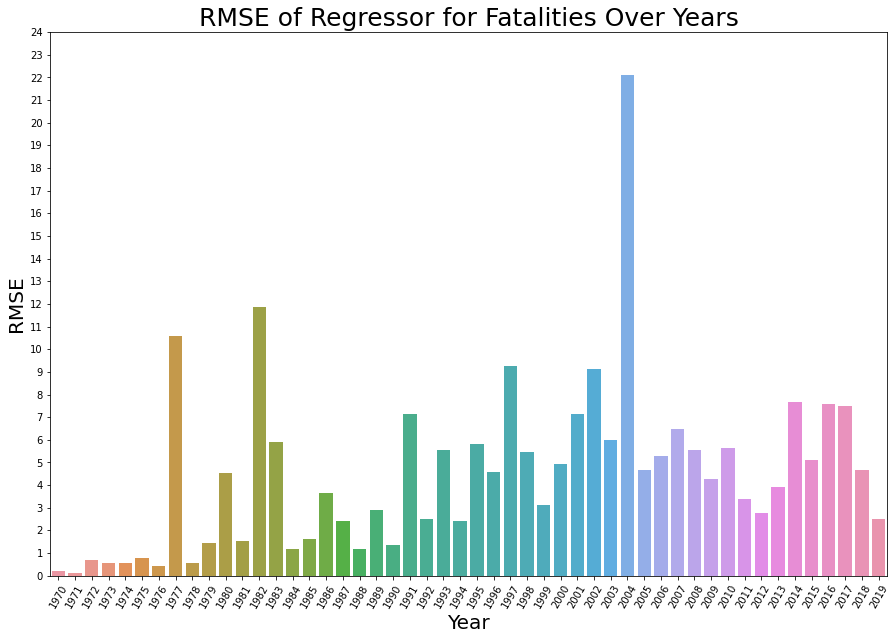

In [13]:
for i in range(0, len(years)):
    print('RMSE for', years[i], 'is', rmse[i])
fig = plt.figure(figsize=(15, 10))
rmse_df = pd.DataFrame(rmse)
ax = sns.barplot(x=years, y=rmse_df[0])
ax.set_title('RMSE of Regressor for Fatalities Over Years', fontsize=25)
ax.set_ylabel("RMSE", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
plt.yticks(np.arange(0, 25, 1))
plt.xticks(rotation=60)
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

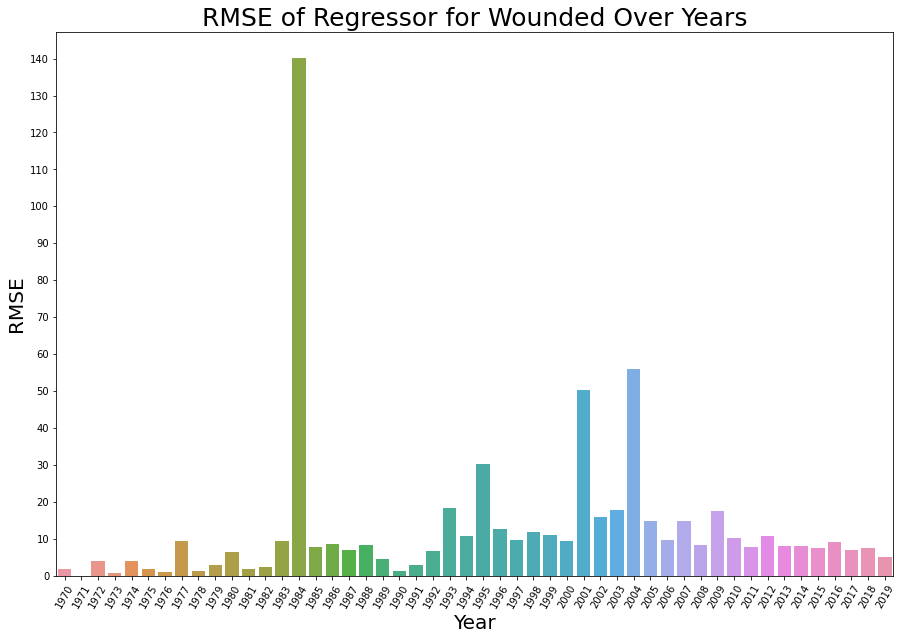

In [214]:
fig = plt.figure(figsize=(15, 10))
ax = sns.barplot(x=years, y=rmse_df[1])
ax.set_title('RMSE of Regressor for Wounded Over Years', fontsize=25)
ax.set_ylabel("RMSE", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
plt.yticks(np.arange(0, 150, 10))
plt.xticks(rotation=60)
plt.show


In [15]:
from statistics import mean
print(mean(rmse_df[0]))
print(mean(rmse_df[1]))


4.524080597277631
12.676830561016843


What would happen to the average rmse for fatalities and wounded if I removed the outliers? For fatalities, 1977, 1982 and 2004 are the outliers while for wounded, it is 1984, 2001 and 2004. 

In [28]:
rmse_fatal_no_outliers = rmse_df[rmse_df[0] < 10]
mean(rmse_fatal_no_outliers[0])


3.8650575551442246

In [29]:
rmse_wound_no_outliers = rmse_df[rmse_df[1] < 40]
mean(rmse_wound_no_outliers[1])


8.239270457572909

Not too much of an effect on the fatalities but a drastic effect on the number of wounded. A average rmse of 3.86 fatalities and 8.23 wounded is pretty solid. 